<a href="https://colab.research.google.com/github/aashrithresearch/endometrial-adenocarcinoma/blob/main/models/googlenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from fastai.vision.all import *
from fastai.callback.fp16 import *
import torch
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/histopathological image dataset for ET'

In [3]:
print(os.listdir(path))

['EA', 'Non EA', 'feature_dict.p', 'lsh.p']


In [4]:
item_tfms = [Resize(224)]
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=item_tfms,
                   batch_tfms=batch_tfms)

dls = dblock.dataloaders(path, bs=64)

In [5]:
train_ds = dls.train_ds
dls = dblock.dataloaders(path)
from collections import Counter
class_counts = Counter([train_ds.items[i].parent.name for i in range(len(train_ds))])

print("Number of samples per class in the training set:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

Number of samples per class in the training set:
Non EA: 2222
EA: 422


In [6]:
valid_ds = dls.valid_ds
valid_class_counts = Counter([valid_ds.items[i].parent.name for i in range(len(valid_ds))])

print("Number of samples per class in the validation set:")
for cls, count in valid_class_counts.items():
    print(f"{cls}: {count}")

Number of samples per class in the validation set:
Non EA: 548
EA: 113


In [7]:
from math import ceil
batch = dls.one_batch()
batch_size = batch[0].shape[0]
ncols = 10
nrows = ceil(batch_size / ncols)

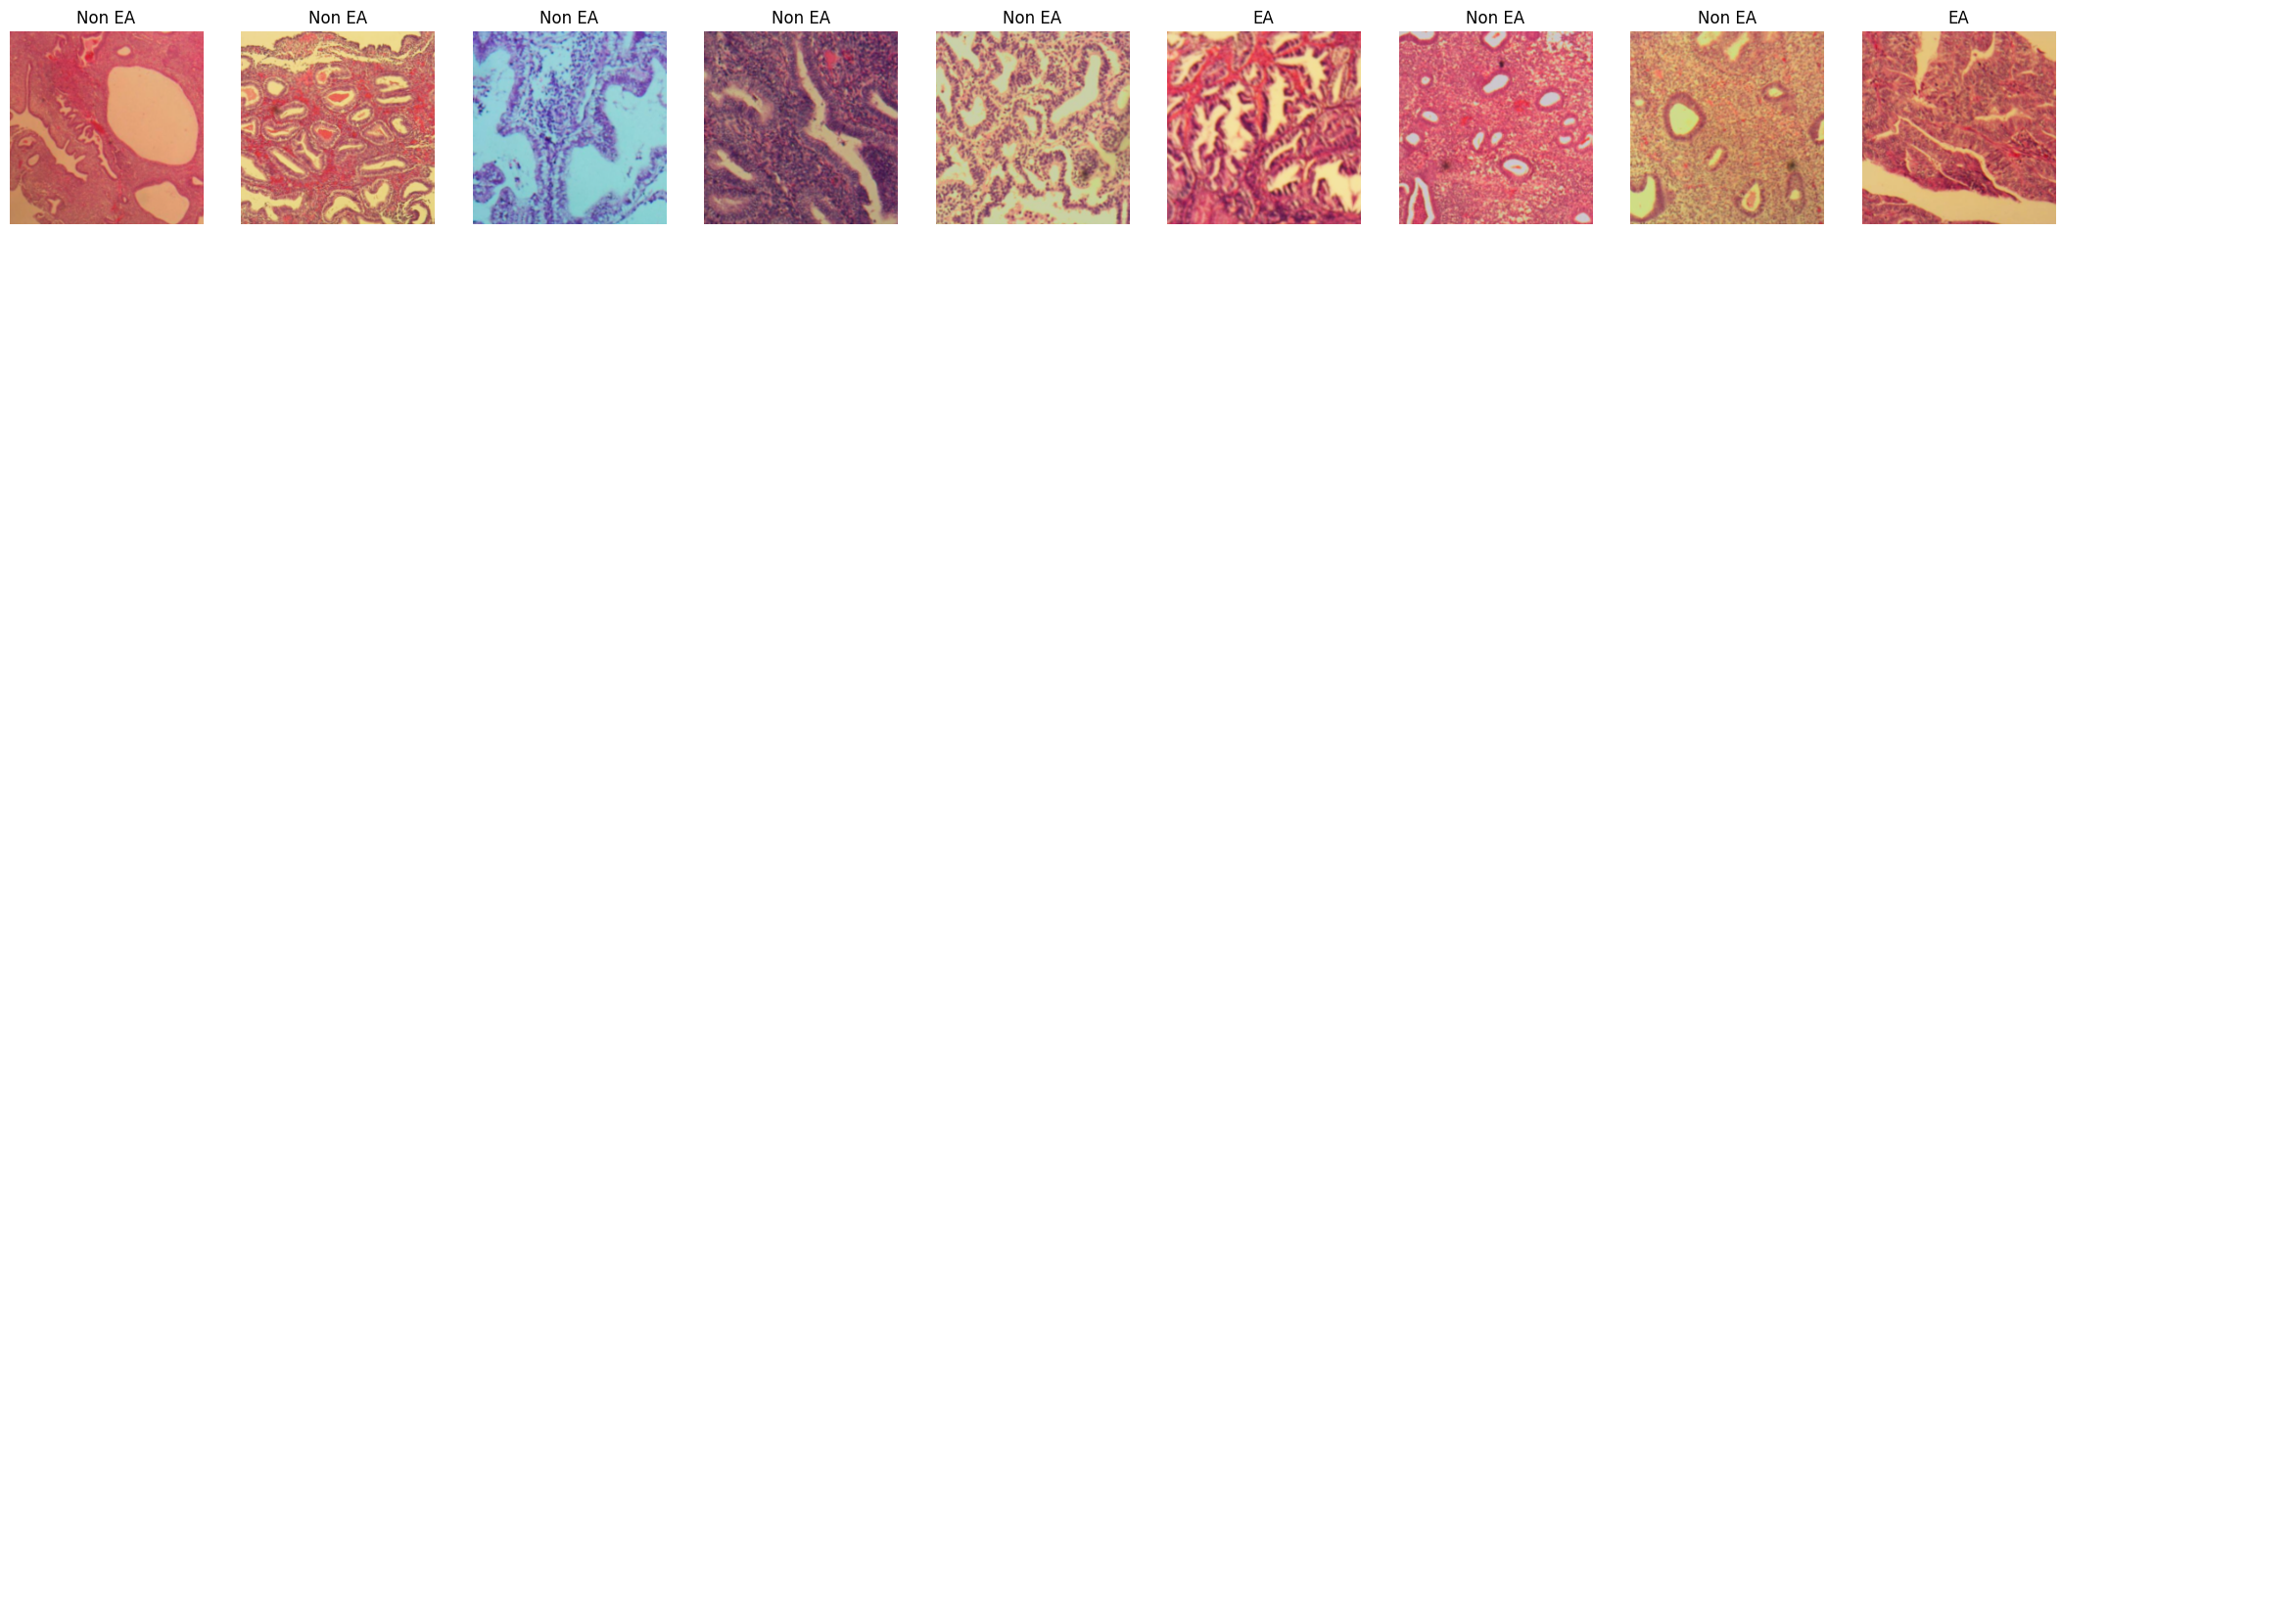

In [8]:
dls.show_batch(nrows=nrows, ncols=10)

In [9]:
metrics = [
    accuracy,
    Precision(average='macro'),
    Recall(average='macro'),
    F1Score(average='macro'),
]
learn = vision_learner(dls, googlenet, metrics=metrics, cbs=[GradientAccumulation(n_acc=16)], loss_func=FocalLoss(), opt_func=Adam).to_fp16()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 54.0MB/s]


SuggestedLRs(valley=0.001737800776027143)

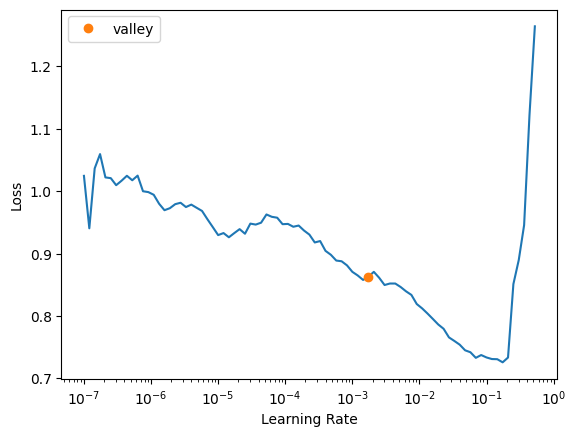

In [10]:
learn.lr_find()

In [11]:
learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.961819,0.251908,0.688351,0.608866,0.678574,0.604049,00:43
1,0.836285,0.231319,0.756430,0.678303,0.789880,0.687751,00:29
2,0.737046,0.215143,0.800303,0.707361,0.816339,0.729031,00:29
3,0.623107,0.201251,0.809380,0.715506,0.825326,0.739138,00:29
4,0.560498,0.169319,0.841150,0.743050,0.844487,0.772013,00:29
5,0.501949,0.161570,0.854766,0.756124,0.849186,0.785836,00:29
6,0.464174,0.142458,0.857791,0.758798,0.847499,0.788141,00:29
7,0.439859,0.144776,0.862330,0.765041,0.857261,0.795431,00:29
8,0.422970,0.132633,0.860817,0.763355,0.856348,0.793712,00:30
9,0.405178,0.136286,0.871407,0.775580,0.862735,0.805901,00:30


In [12]:
learn.save('googlenet-10ep stage1')

Path('models/googlenet-10ep stage1.pth')

SuggestedLRs(valley=5.754399353463668e-06)

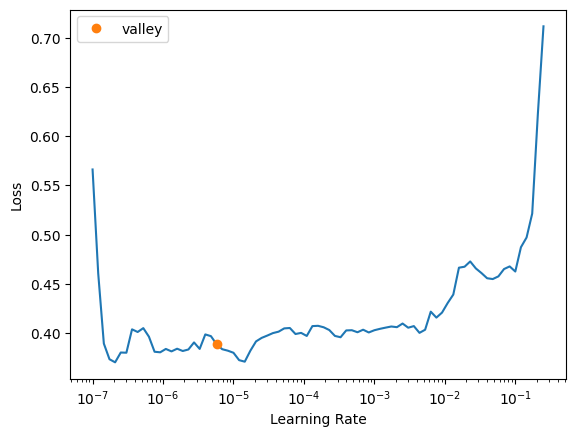

In [13]:
learn.unfreeze()
learn.lr_find()

In [14]:
learn.fit_one_cycle(10, 1e-6)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.435376,0.136198,0.863843,0.766747,0.858173,0.797156,00:31
1,0.422475,0.141371,0.859304,0.761687,0.855436,0.792001,00:30
2,0.412738,0.132065,0.868381,0.771985,0.860910,0.802379,00:30
3,0.425413,0.131089,0.874433,0.779262,0.864560,0.809454,00:30
4,0.392811,0.128326,0.866868,0.770219,0.859998,0.800631,00:30
5,0.402052,0.132267,0.869894,0.773772,0.861823,0.804136,00:31
6,0.394693,0.138928,0.860817,0.763355,0.856348,0.793712,00:31
7,0.398056,0.143033,0.862330,0.765041,0.857261,0.795431,00:30
8,0.415255,0.139333,0.869894,0.773772,0.861823,0.804136,00:31
9,0.403386,0.138507,0.863843,0.766747,0.858173,0.797156,00:31


In [15]:
learn.save('googlenet-10ep stage2')

Path('models/googlenet-10ep stage2.pth')

SuggestedLRs(valley=0.0008317637839354575)

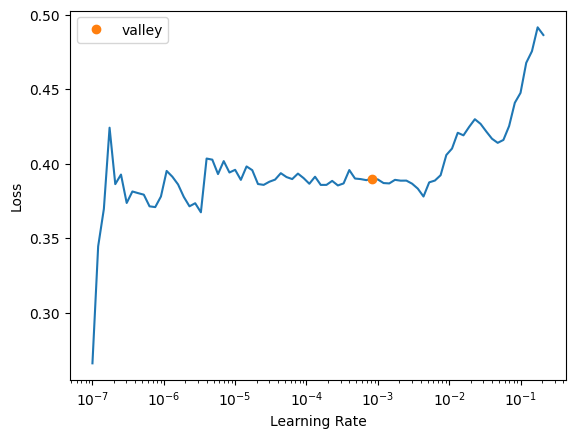

In [16]:
learn.unfreeze()
learn.lr_find()

In [17]:
learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.404831,0.131619,0.878971,0.784955,0.867297,0.814846,00:30
1,0.398192,0.125206,0.877458,0.783034,0.866385,0.813040,00:30
2,0.354496,0.135378,0.883510,0.791280,0.877059,0.822273,00:30
3,0.319529,0.098342,0.907716,0.825771,0.891658,0.852684,00:31
4,0.260523,0.081229,0.922844,0.863113,0.865658,0.864378,00:30
5,0.218750,0.074912,0.933434,0.893282,0.865020,0.878257,00:32
6,0.182930,0.075106,0.937973,0.900635,0.874782,0.886978,00:32
7,0.170205,0.072221,0.933434,0.888652,0.872045,0.880036,00:31
8,0.161249,0.084743,0.931921,0.877286,0.885182,0.881161,00:31
9,0.145013,0.080784,0.930408,0.875506,0.880757,0.878099,00:31


In [18]:
learn.save('googlenet-10ep stage3')

Path('models/googlenet-10ep stage3.pth')

SuggestedLRs(valley=0.00019054606673307717)

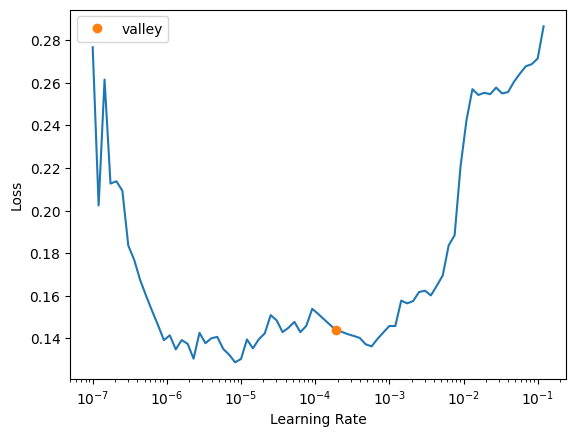

In [19]:
learn.unfreeze()
learn.lr_find()

In [20]:
learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.137664,0.076672,0.927383,0.870242,0.875420,0.872799,00:31
1,0.139405,0.079935,0.939486,0.902227,0.879207,0.890141,00:31
2,0.113903,0.081887,0.937973,0.895871,0.881807,0.888620,00:32
3,0.101745,0.080424,0.931921,0.880839,0.878157,0.879490,00:31
4,0.096605,0.091895,0.930408,0.879083,0.873732,0.876374,00:31
5,0.075978,0.082020,0.937973,0.884288,0.902881,0.893193,00:31
6,0.076235,0.072064,0.942511,0.910533,0.881032,0.894858,00:31
7,0.062772,0.068211,0.944024,0.914808,0.881944,0.897242,00:31
8,0.056639,0.071294,0.945537,0.919165,0.882856,0.899642,00:31
9,0.064889,0.077747,0.945537,0.906151,0.900418,0.903249,00:31


In [21]:
learn.save('googlenet-10ep stage4')

Path('models/googlenet-10ep stage4.pth')